In [1]:
import os
import time
import itertools
import multiprocessing
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

In [2]:
np.warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 10)
n_cores = multiprocessing.cpu_count()

In [3]:
f = './data/raw/A2005105004500.L2_LAC_SST.nc'
data = xr.open_dataset(f, group='geophysical_data', engine='h5netcdf', mask_and_scale=True)
sst = np.array(data['sst'])
qual = np.array(data['qual_sst'])

In [4]:
sst[np.isnan(sst)] = np.nan

([], <a list of 0 Text major ticklabel objects>)

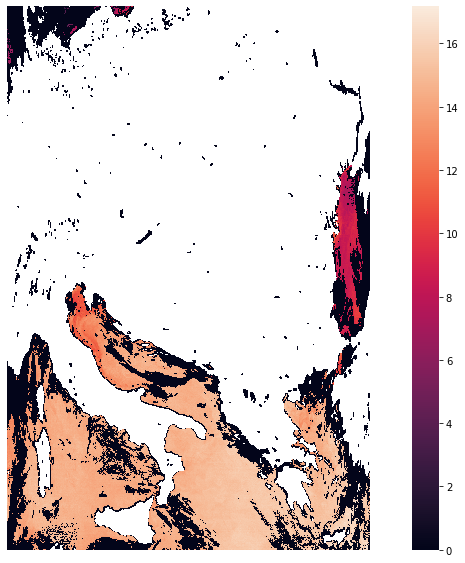

In [5]:
mask = ~((qual > 2) | (sst < -2.) | (sst > 33.))
sns.heatmap(mask*sst, square=True)
plt.xticks([]); plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

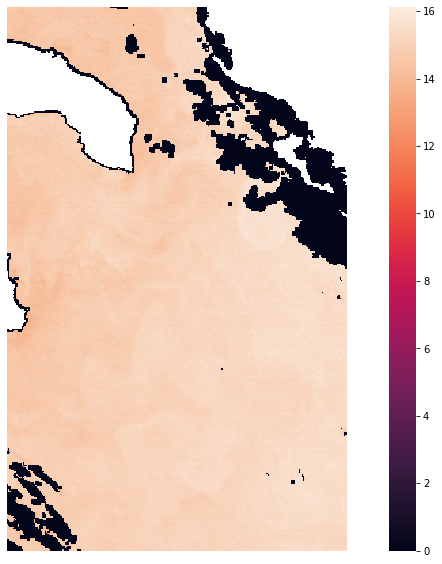

In [6]:
sns.heatmap((mask*sst)[1500:1900, 650:900], square=True)
plt.xticks([]); plt.yticks([])

In [7]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    blocks = (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
    locs = list(itertools.product(np.arange(h // nrows), np.arange(w // ncols)))
    return blocks, np.array(locs)

In [8]:
def extract_fields(f, field_size=(96, 96), clear_thresh=0.9, 
                   qual_thresh=2, nadir_offset=480, temp_bounds=(-2, 33)):
    
    filename = os.path.join('./data/raw', f)
    data = xr.open_dataset(filename, group='geophysical_data', 
                           engine='h5netcdf', mask_and_scale=True)
    
    sst = np.array(data['sst'])
    qual = np.array(data['qual_sst'])
    
    sst[np.isnan(sst)] = np.nan
    mask = (qual > qual_thresh) | (sst <= temp_bounds[0]) | (sst > temp_bounds[1])
    sst[mask] = np.nan
    
    nadir_pix = sst.shape[1] // 2
    lb = nadir_pix - nadir_offset
    ub = nadir_pix + nadir_offset
    height = (sst.shape[0] // field_size[0]) * field_size[0]
    sst = sst[:height, lb:ub]
    
    fields, locs = blockshaped(sst, *field_size)
    
    clear_fields, metadata = [], []
    for field, loc in zip(fields, locs):
        if (1. - np.isnan(field).sum() / field.size) > clear_thresh:
            clear_fields.append(field)
            ax0_lims = (loc[0]*field_size[0], (loc[0]+1)*field_size[0])
            ax1_lims = (lb + loc[1]*field_size[1], lb + (loc[1]+1)*field_size[1])
            metadata.append((f, ax0_lims, ax1_lims))
    
    if len(clear_fields) == 0:
        return
    else:
        return np.stack(clear_fields), np.stack(metadata)

In [9]:
f = 'A2005105004500.L2_LAC_SST.nc'
fields, meta = extract_fields(f)

In [10]:
from functools import partial

In [41]:
threshes = np.arange(0.9, 1.005, 0.005)
n_fields = []
with ProcessPoolExecutor(max_workers=n_cores) as executor:
    for clear_thresh in tqdm(threshes):
        map_fn = partial(extract_fields, clear_thresh=clear_thresh)
        files = os.listdir('./data/raw')
        fields = list(tqdm(executor.map(map_fn, files, chunksize=len(files)//n_cores), total=len(files)))
        fields, metadata = np.array([f for f in fields if f is not None]).T
        fields, metadata = np.vstack(fields), np.vstack(metadata)
        n_fields.append(fields.shape[0])

 95%|█████████▌| 20/21 [01:22<00:04,  4.15s/it]


ValueError: not enough values to unpack (expected 2, got 0)

Text(0.5, 1.0, 'Number of Fields vs. Clear Fraction (501 Total Files)')

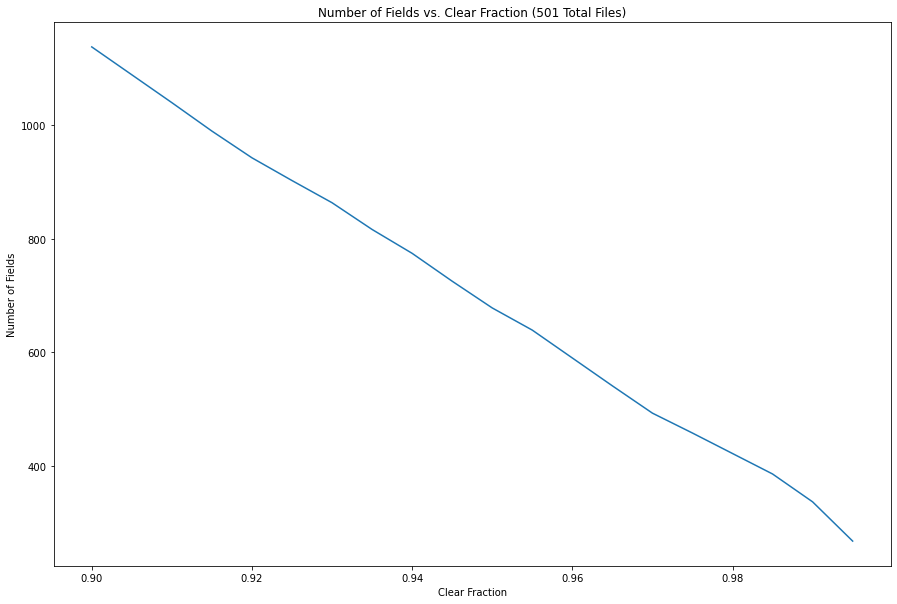

In [43]:
plt.plot(threshes[:-1], n_fields)
plt.ylabel('Number of Fields')
plt.xlabel('Clear Fraction')
plt.title('Number of Fields vs. Clear Fraction (501 Total Files)')

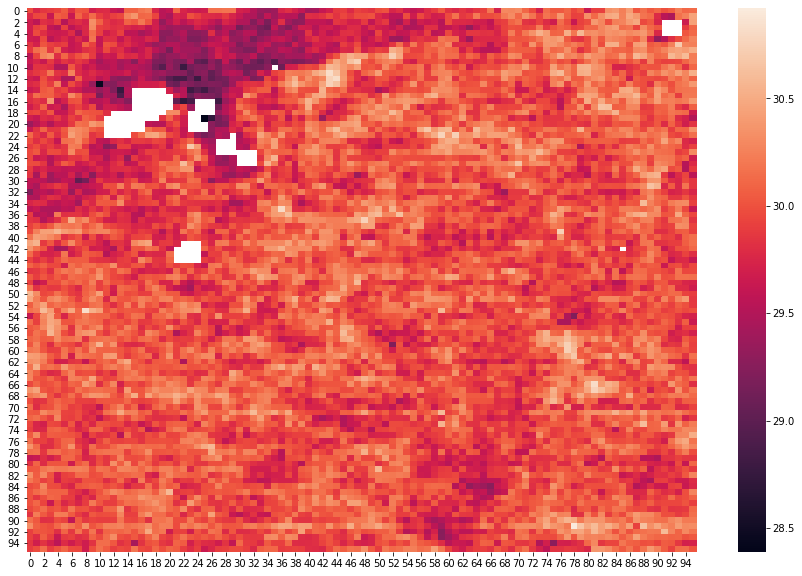

In [12]:
idx = np.random.choice(fields.shape[0])
sns.heatmap(fields[idx])

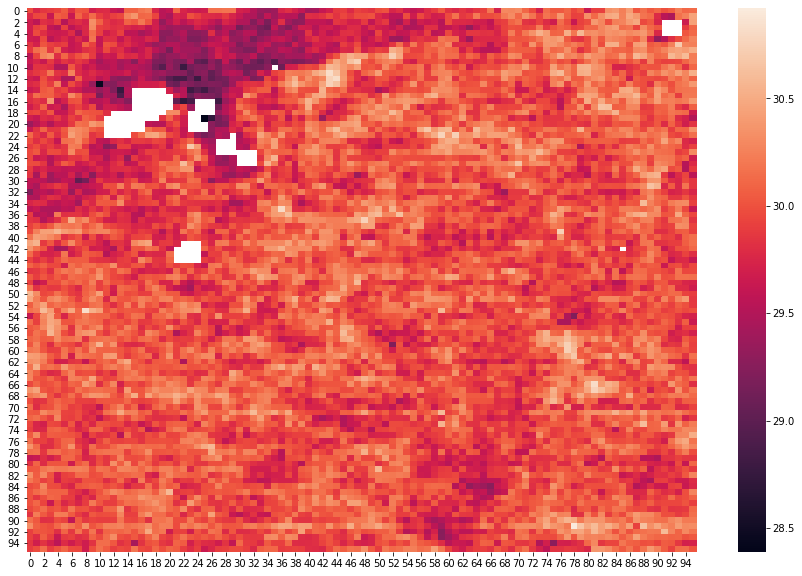

In [15]:
f, xlim, ylim = metadata[idx]
filename = os.path.join('./data/raw/', f)
data = xr.open_dataset(filename, group='geophysical_data', 
                       engine='h5netcdf', mask_and_scale=True)

sst = np.array(data['sst'])
qual = np.array(data['qual_sst'])
mask = (qual > 2) | (sst <= -2) | (sst > 33)
sst[mask] = np.nan

sns.heatmap(sst[xlim[0]:xlim[1], ylim[0]:ylim[1]])

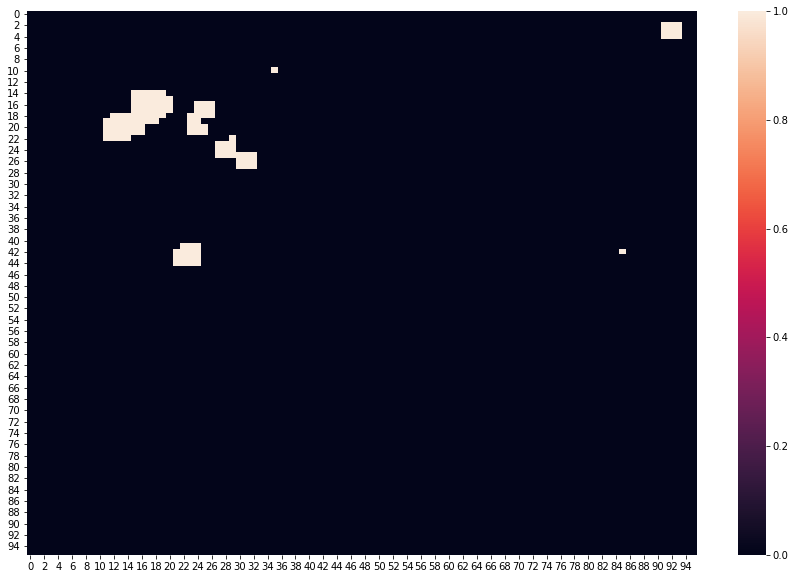

In [25]:
sns.heatmap(mask[xlim[0]:xlim[1], ylim[0]:ylim[1]])

In [21]:
fields[~np.isnan(fields)].min()

-0.24

In [22]:
fields.shape, metadata.shape

((1137, 96, 96), (1137, 3))

In [23]:
np.savez_compressed('./data/processed/MODIS_night_data', fields=fields, metadata=metadata)